In [1]:
import numpy as np
import uproot
%matplotlib inline
from coffea import hist
#from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np

In [2]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        # Split data into 50 bins, ranging from 0 to 100.
        
        Muon_axis = hist.Bin("Muon", "Muon [GeV]", 50, 0, 100)
        Electron_axis = hist.Bin("Electron", "Electron [GeV]", 50, 0, 100)
        Loose_muon_axis = hist.Bin("Electron", "Electron [GeV]", 50, 0, 100)
        Test_axis = hist.Bin("Test", "Test [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'Muon': hist.Hist("Counts", dataset_axis, Muon_axis),
            'Electron': hist.Hist("Counts", dataset_axis, Electron_axis),
            'Test': hist.Hist("Counts", dataset_axis, Test_axis)
            #'nMuon': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        # Skim Muon, Electron, and Jet
        Muon = events.Muon
        Muon = Muon[( Muon.pt >10 ) &
                           (np.abs(Muon.eta) < 2.4) &
                           (np.abs(Muon.dxy) < 0.05) &
                           (np.abs(Muon.dz) < 0.1) &
                           (np.abs(Muon.sip3d) < 4) &
                           (Muon.looseId==1) &
                           (Muon.ptErr/Muon.pt < 0.2) &
                           (Muon.mediumId==1) ]
        
        Electron = events.Electron
        Electron = Electron[( Electron.pt >10 ) &  #  (Electron.isTriggerSafeNolso) 
                           (np.abs(Electron.eta+Electron.deltaEtaSC ) < 2.4) &
                            (Electron.convVeto)&
                            (Electron.lostHits==0) &
                            (Electron.tightCharge==2) &
                            (np.abs(Electron.dz) < 0.1) &
                           (np.abs(Electron.dxy) < 0.05) &
                           (np.abs(Electron.sip3d) < 4) ]
        Jet = events.Jet
        Jet = Jet[( Jet.pt >25 ) &  (np.abs(Jet.eta ) < 2.4) ]

        
        def delta_phi(first, second):
            return np.arccos(np.cos(first.phi - second.phi))

        def delta_r2(first, second):
            return (first.eta - second.eta) ** 2 + delta_phi(first, second) ** 2

        def match(first, second, deltaRCut=0.4):
            drCut2 = deltaRCut**2
            combs = ak.cartesian([first, second], nested=True)
            return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)    
        
        def mt(pt1, phi1, pt2, phi2):    #transverse mass
            return np.sqrt( 2*pt1*pt2 * (1 - np.cos(phi1-phi2)) )
        
        # Definition of Tight/Loose Muon and Electron
        Tight_Muon = Muon[( Muon.pt >20 ) &
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.tightId==1) &
                          (Muon.miniPFRelIso_all<0.16)
                         ]
        Tight_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                       #  (Electron.tightId==1) &
                          (Electron.miniPFRelIso_all<0.12)
                         ]
        
        Loose_Muon = Muon[( Muon.pt >20 )&
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.looseId==1) &
                          (Muon.miniPFRelIso_all<0.4)
                         ]        
        
        Loose_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                        # (Electron.looseId==1) &
                          (Electron.miniPFRelIso_all<0.4)
                         ]
        MET = events.MET   
        

        control_region_Muon = ev[( ak.num(Loose_Muon)==1) &(ak.num(Loose_Electron)==0)
                                    & (ak.num(Jet[~match(Jet, Muon, deltaRCut=1.0)])>=1) & ( MET.pt<20) 
                                    & ak.any(mt(Muon.pt,Muon.phi, MET.pt, MET.phi)<20, axis=1)]


        tight_muon= control_region_Muon.Muon[(control_region_Muon.Muon.pt >20 ) &
                          (np.abs(control_region_Muon.Muon.eta) < 2.4) &
                         (control_region_Muon.Muon.tightId==1) &
                          (control_region_Muon.Muon.miniPFRelIso_all<0.16)
                         ]

    
        
        
        #Temporary Output fills 
        output['Muon'].fill(dataset=dataset, Muon=ak.flatten(Muon.pt))
        output['Electron'].fill(dataset=dataset, Electron=ak.flatten(Electron.pt))
        output['Test'].fill(dataset=dataset, Test=ak.flatten(control_region_Muon.Muon.pt))
        #return output

    def postprocess(self, accumulator):
        return accumulator

In [180]:
#fileset = {'SingleMu' : ["root://xcache//store/mc/RunIISummer16NanoAODv7/QCD_Pt-20to30_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/60000/30AED9F5-92AD-DD46-A547-61765FD6B596.root"]}

fileset = {'SingleMu' : ['root://xcache//store/mc/RunIISummer16NanoAODv7/QCD_Pt-20to30_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/60000/30AED9F5-92AD-DD46-A547-61765FD6B596.root']}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=Processor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4,"schema": NanoAODSchema},
                                 chunksize = 250000)


<event 1:162370:211330333>
<event 1:14930:414349995>

<event 1:63893:1773215996>
<event 1:139222:3863812480>
<event 1:60833:1688304030>
<event 1:101441:2815301419>


ValueError: cannot use records as a slice

(https://github.com/scikit-hep/awkward-1.0/blob/1.1.2/src/libawkward/array/RecordArray.cpp#L1399)

Failed processing file: root://xcache//store/mc/RunIISummer16NanoAODv7/QCD_Pt-20to30_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/60000/30AED9F5-92AD-DD46-A547-61765FD6B596.root (754935-1006580)

### Debugging

In [3]:
s = "root://xcache//store/mc/RunIISummer16NanoAODv7/QCD_Pt-20to30_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/60000/30AED9F5-92AD-DD46-A547-61765FD6B596.root"

In [4]:
ev = NanoEventsFactory.from_root(s, schemaclass=NanoAODSchema).events()

In [5]:
# Running what's in the processor here for easier manipulation
Muon = ev.Muon
Muon = Muon[( Muon.pt >10 ) &
                           (np.abs(Muon.eta) < 2.4) &
                           (np.abs(Muon.dxy) < 0.05) &
                           (np.abs(Muon.dz) < 0.1) &
                           (np.abs(Muon.sip3d) < 4) &
                           (Muon.looseId==1) &
                           (Muon.ptErr/Muon.pt < 0.2) &
                           (Muon.mediumId==1) ]
        
Electron = ev.Electron
Electron = Electron[( Electron.pt >10 ) &  #  (Electron.isTriggerSafeNolso) 
                           (np.abs(Electron.eta+Electron.deltaEtaSC ) < 2.4) &
                            (Electron.convVeto)&
                            (Electron.lostHits==0) &
                            (Electron.tightCharge==2) &
                            (np.abs(Electron.dz) < 0.1) &
                           (np.abs(Electron.dxy) < 0.05) &
                           (np.abs(Electron.sip3d) < 4) ]
Jet = ev.Jet
Jet = Jet[( Jet.pt >25 ) &  (np.abs(Jet.eta ) < 2.4) ]

def delta_phi(first, second):
            return np.arccos(np.cos(first.phi - second.phi))

def delta_r2(first, second):
            return (first.eta - second.eta) ** 2 + delta_phi(first, second) ** 2

def match(first, second, deltaRCut=0.4):
            drCut2 = deltaRCut**2
            combs = ak.cartesian([first, second], nested=True)
            return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)    
        
def mt(pt1, phi1, pt2, phi2):    #transverse mass
            return np.sqrt( 2*pt1*pt2 * (1 - np.cos(phi1-phi2)) )
        
# Definition of Tight/Loose Muon and Electron
Tight_Muon = Muon[( Muon.pt >20 ) &
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.tightId==1) &
                          (Muon.miniPFRelIso_all<0.16)
                         ]
Tight_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                       #  (Electron.tightId==1) &
                          (Electron.miniPFRelIso_all<0.12)
                         ]
        
Loose_Muon = Muon[( Muon.pt >20 )&
                          (np.abs(Muon.eta) < 2.4) &
                         (Muon.looseId==1) &
                          (Muon.miniPFRelIso_all<0.4)
                         ]        
        
Loose_Electron = Electron[( Electron.pt >20 )&
                          (np.abs(Electron.eta) < 2.4) &
                        # (Electron.looseId==1) &
                          (Electron.miniPFRelIso_all<0.4)
                         ]
MET = ev.MET   
        

control_region_Muon = ev[( ak.num(Loose_Muon)==1) &(ak.num(Loose_Electron)==0)
                                    & (ak.num(Jet[~match(Jet, Muon, deltaRCut=1.0)])>=1) & ( MET.pt<20) 
                                    & ak.any(mt(Muon.pt,Muon.phi, MET.pt, MET.phi)<20, axis=1)]


tight_muon= control_region_Muon.Muon[(control_region_Muon.Muon.pt >20 ) &
                          (np.abs(control_region_Muon.Muon.eta) < 2.4) &
                         (control_region_Muon.Muon.tightId==1) &
                          (control_region_Muon.Muon.miniPFRelIso_all<0.16)
                         ]

### Plotting
https://github.com/cmstas/FTAnalysis/blob/run2/analysis/fakes/derivation/ScanChain_fast.C#L161

In [72]:
import matplotlib.pyplot as plt

In [10]:
nptbins = 7
ptbins = [10., 15., 20., 25., 35., 50., 70., 90.]
netabins = 3
etabins_mu = [0., 1.2, 2.1, 2.4]
etabins_el = [0., 0.8, 1.479, 2.5]

In [78]:
percentage_muon = np.zeros((netabins,nptbins))

for i in range(netabins):
    for j in range(nptbins):
        total = sum(ak.num(control_region_Muon.Muon[(control_region_Muon.Muon.pt>=ptbins[j]) & (control_region_Muon.Muon.pt<ptbins[j+1])&(control_region_Muon.Muon.eta<etabins_mu[i+1])&(control_region_Muon.Muon.eta>=etabins_mu[i])]))
        tight = sum(ak.num(tight_muon[(tight_muon.pt>=ptbins[j]) & (tight_muon.pt<ptbins[j+1])&(tight_muon.eta<etabins_mu[i+1])&(tight_muon.eta>=etabins_mu[i])]))
        if total!=0:
            percentage_muon[i,j] = tight/total

In [79]:
percentage_muon

array([[0.        , 0.        , 0.5       , 0.66666667, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.63636364, 1.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.        , 0.        ,
        0.        , 0.        ]])

#### Need control region for electron

In [ ]:
percentage2 = np.zeros((netabins,nptbins))

for i in range(netabins):
    for j in range(nptbins):
        total = sum(ak.num(control_region_Muon.Muon[(control_region_Muon.Muon.pt>=ptbins[j]) & (control_region_Muon.Muon.pt<ptbins[j+1])&(control_region_Muon.Muon.eta<etabins_mu[i+1])&(control_region_Muon.Muon.eta>=etabins_mu[i])]))
        tight = sum(ak.num(tight_muon[(tight_muon.pt>=ptbins[j]) & (tight_muon.pt<ptbins[j+1])&(tight_muon.eta<etabins_mu[i+1])&(tight_muon.eta>=etabins_mu[i])]))
        if total!=0:
            percentage1[i,j] = tight/total

In [ ]:
percentage2

1.2
1.2
1.2
1.2
1.2
1.2
1.2
2.1
2.1
2.1
2.1
2.1
2.1
2.1
2.4
2.4
2.4
2.4
2.4
2.4
2.4
1.2
1.2
1.2
1.2
1.2
1.2
1.2
2.1
2.1
2.1
2.1
2.1
2.1
2.1
2.4
2.4
2.4
2.4
2.4
2.4
2.4


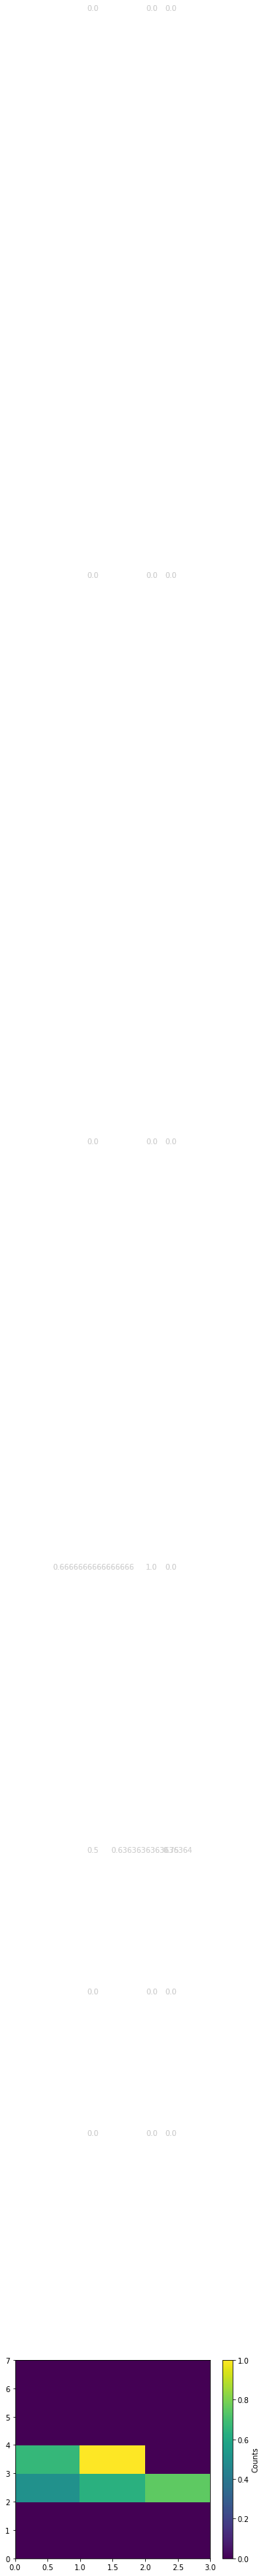

In [151]:
fig, ax = plt.subplots(figsize=(6, 5))  # need some extra room for the colorbar

xmesh1, ymesh1= np.meshgrid(ptbins, etabins_mu)
xmesh, ymesh= np.meshgrid(xedges, yedges)
# pcolormesh assumes the array is (y,x) ordered!
#pc = ax.pcolormesh(xmesh, ymesh, pdf_xy.T)
pc = ax.pcolormesh(percentage_muon.T)
fig.colorbar(pc, ax=ax, label='Counts')

# text annotation appears to be a manual operation
# c.f. https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
#for ix, xc in enumerate(np.array(etabins_mu[:-1] + etabins_mu[1:])/2):
for ix, xc in enumerate(etabins_mu[1:]):
    for iy, yc in enumerate(ptbins[1:]):
        #color = 'black' if pc.norm(pdf_xy[ix, iy]) > 0.5 else 'lightgrey'
        print(xc)
        ax.text(xc, yc, percentage_muon[ix, iy], ha='center', va='center', color=color)
        
for ix, xc in enumerate(etabins_mu[1:]):
    for iy, yc in enumerate(ptbins[1:]):
        #color = 'black' if pc.norm(pdf_xy[ix, iy]) > 0.5 else 'lightgrey'
        print(xc)
        ax.text(xc, yc, percentage_muon[ix, iy], ha='center', va='center', color=color)

In [149]:
percentage_muon

array([[0.        , 0.        , 0.5       , 0.66666667, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.63636364, 1.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.        , 0.        ,
        0.        , 0.        ]])

In [121]:
for iy, yc in enumerate(ptbins):
    print(iy)

0
1
2
3
4
5
6
7
